<a href="https://colab.research.google.com/github/lucasrgoldman/AuthorVerification/blob/main/Stylometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt update
!apt install enchant --fix-missing
!apt install -qq enchant
!pip install pyenchant

aspell-autobuildhash: processing: en [en-variant_0].
aspell-autobuildhash: processing: en [en-variant_1].
aspell-autobuildhash: processing: en [en-variant_2].
aspell-autobuildhash: processing: en [en-w_accents-only].
aspell-autobuildhash: processing: en [en-wo_accents-only].
aspell-autobuildhash: processing: en [en_AU-variant_0].
aspell-autobuildhash: processing: en [en_AU-variant_1].
aspell-autobuildhash: processing: en [en_AU-w_accents-only].
aspell-autobuildhash: processing: en [en_AU-wo_accents-only].
aspell-autobuildhash: processing: en [en_CA-variant_0].
aspell-autobuildhash: processing: en [en_CA-variant_1].
aspell-autobuildhash: processing: en [en_CA-w_accents-only].
aspell-autobuildhash: processing: en [en_CA-wo_accents-only].
aspell-autobuildhash: processing: en [en_GB-ise-w_accents-only].
aspell-autobuildhash: processing: en [en_GB-ise-wo_accents-only].
aspell-autobuildhash: processing: en [en_GB-ize-w_accents-only].
aspell-autobuildhash: processing: en [en_GB-ize-wo_accents

In [ ]:
from google.colab import drive
import os
from pathlib import Path
import pandas as pd
import re
import numpy as np
import enchant
import nltk
import glob
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import BlanklineTokenizer
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
drive.mount('/content/drive', force_remount=True)
path = Path(os.getcwd())
gdrive = path = path/'drive'/'My Drive'/'ML Data'

# victorian = pd.read_csv(gdrive/'Victorian.csv', names = ["text"], encoding = "unicode_escape", header = 0)
victorian = pd.read_csv(gdrive/'imdb1m-posts.txt', sep = '\t', names = ["postId", "userId", "title", "text"])
# victorian['text'] = victorian['text'].apply(str)

path = str(gdrive/"federalist/federalist_") + str(1) + ".txt"
text = pd.read_csv(path, sep = ' ', header=None)[0].str.cat(sep = " ")
main_dataframe = pd.DataFrame([text], columns=['text'])
  
for i in range(1, 85):
  path = str(gdrive/"federalist/federalist_") + str(i + 1) + ".txt"
  text = pd.read_csv(path, sep = ' ', header = None)[0].str.cat(sep = " ")
  tmp_df = pd.DataFrame([text], columns=['text'])
  main_dataframe = pd.concat([main_dataframe,tmp_df],axis = 0, ignore_index=True)

Mounted at /content/drive


ParserError: ignored

In [ ]:
from nltk.metrics import edit_distance

class SpellingReplacer:
    def __init__(self, dict_name='en_GB', max_dist=3):
        self.spell_dict = enchant.Dict(dict_name)
        self.max_dist = 3

    def replace(self, word):
        if self.spell_dict.check(word):
            return 0
        suggestions = self.spell_dict.suggest(word)

        if suggestions and edit_distance(word, suggestions[0]) <= self.max_dist:
            return 1
        else:
            return 0


def spell_check(word_list):
    number_wrong = 0
    for item in word_list:
        replacer = SpellingReplacer()
        number_wrong = number_wrong + replacer.replace(item)

    return number_wrong

In [ ]:
def get_misspell(text):
  return spell_check(text)

def add_stylometry(df):
  tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
  sent_tokenizer = nltk.tokenize.sent_tokenize
  df["Characters"] = df.text.str.len() 
  df["Words"] = df.text.apply(tokenizer.tokenize).apply(len)
  df["Captials"] = df.text.str.findall(r'[A-Z]').str.len()
  df["Paragraphs"] = df.text.apply(BlanklineTokenizer().tokenize).apply(len)
  df["Sentences"] = df.text.apply(sent_tokenizer).apply(len)
  df["Characters Per Word"] = df["Characters"] / df["Words"]
  df["Words Per Sentence"] = df["Words"] / df["Sentences"]
  df["Sentences Per Paragraph"] = df["Sentences"] / df["Paragraphs"]
  df["Words in First Paragraph"] = df.text.apply(BlanklineTokenizer().tokenize).str[0].apply(len)
  df["Words in Last Paragraph"] = df.text.apply(BlanklineTokenizer().tokenize).str[-1].apply(len)
  df["First / Last"] = df["Words in First Paragraph"] / df["Words in Last Paragraph"]
  df["Tokens"] =  df.text.apply(nltk.word_tokenize)
  df["Misspellings"] = df.Tokens.apply(get_misspell)
  df["Misspelling Ratio"] = df.Misspellings / df.Words
  df = df.drop("Tokens", axis = 1)
  return df

federalist_stylo = add_stylometry(main_dataframe)
federalist_stylo = federalist_stylo.drop("text", axis = 1)


In [ ]:
Madison = [9, 13, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
Hamilton = [0, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 20, 21, 22, 23, 24, 
            25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 58, 59, 60, 
            64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 
            78, 79, 80, 81, 82, 83, 84]
Jay = [1, 2, 3, 4]
Shared = [17, 18, 19]
Disputed = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 61, 62]
TestCase = [63]


federalist_stylo['Hamilton'] = 0
for i in range(0, 84):
  if(i in Hamilton):
    federalist_stylo['Hamilton'][i] = 1
  else:
    federalist_stylo['Hamilton'][i] = 0

train = federalist_stylo.drop(labels = Disputed + TestCase, axis = 0)
train_Y = train.Hamilton
train_Y = train_Y.array

train_X = train.drop(labels = "Hamilton", axis = 1)
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)


test = federalist_stylo.drop(labels = Madison + Hamilton + Jay + Shared, axis = 0)
test_Y = test.Hamilton
test_Y = test_Y.array
test_X = test.drop(labels = "Hamilton", axis = 1)
test_X = scaler.transform(test_X)

<ipython-input-144-fc4cbb4f1b69>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  federalist_stylo['Hamilton'][i] = 1
<ipython-input-144-fc4cbb4f1b69>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  federalist_stylo['Hamilton'][i] = 0


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(train_X, train_Y)
train_Y_pred = clf.predict(train_X) 
correct = [1 if train_Y_pred[i] == train_Y[i] else 0 for i in range(0, 72)]
sum(correct)/len(correct)


In [ ]:
# Train accuracy

test_Y_pred = clf.predict(test_X)
correct = [1 if test_Y_pred[i] == test_Y[i] else 0 for i in range(0, len(test_Y_pred))]
sum(correct)/len(correct)

NameError: ignored

In [ ]:
drive.mount('/content/drive', force_remount=True)
path = Path(os.getcwd())
gdrive = path = path/'drive'/'My Drive'
#gdrive/federalist/


papers = {
    'Madison': [10, 14, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
    'Hamilton': [1, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 21, 22, 23, 24,
                 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 59, 60,
                 61, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
                 78, 79, 80, 81, 82, 83, 84, 85],
    'Jay': [2, 3, 4, 5],
    'Shared': [18, 19, 20],
    'Disputed': [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 62, 63],
    'TestCase': [64]
}

def read_files_into_string(filenames):
    strings = []
    for filename in filenames:
        path = 'federalist/federalist_' + str(filename) + '.txt'
        with open(gdrive/path, 'r') as f:
            strings.append(f.read())
    return '\n'.join(strings)

federalist_by_author = {}
for author, files in papers.items():
    federalist_by_author[author] = read_files_into_string(files)

#for author in papers:
#    print(federalist_by_author[author][:100])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


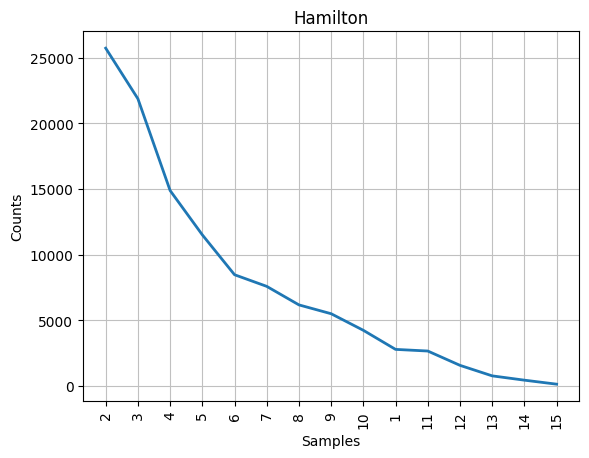

Avearge word Length:
{'Hamilton': 4.796835598206781}


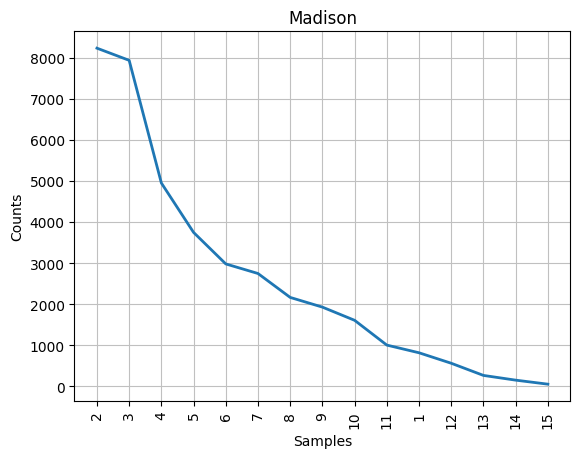

Avearge word Length:
{'Madison': 4.900949900413666}


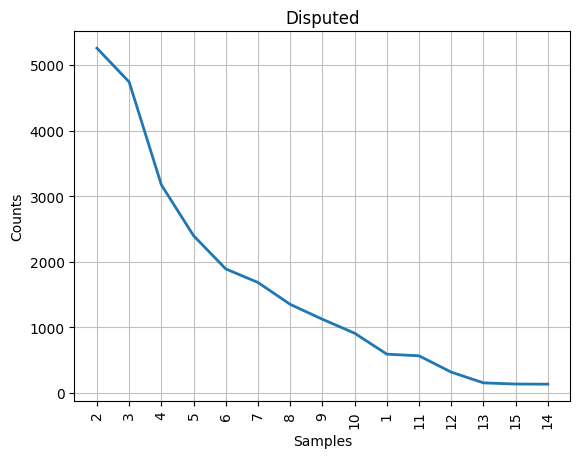

Avearge word Length:
{'Disputed': 4.870453147426697}


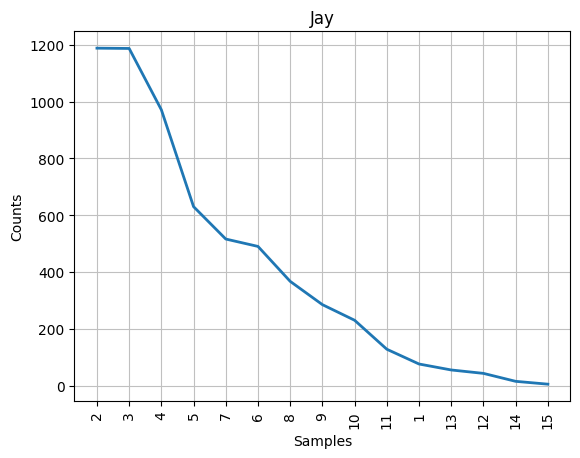

Avearge word Length:
{'Jay': 4.90203685741998}


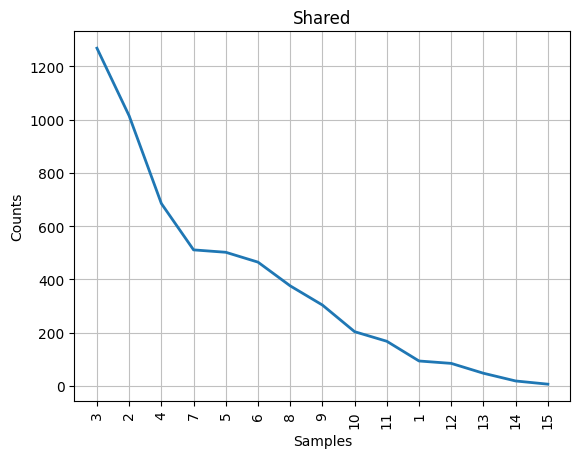

Avearge word Length:
{'Shared': 5.0832609073526855}


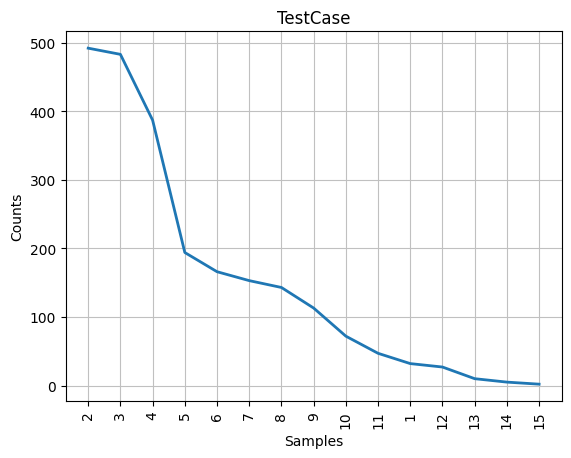

Avearge word Length:
{'TestCase': 4.734851740438333}
punctuation
{'Hamilton': ['.', ',', ',', ':', ',', '.', ';', ',', ',', '.', ',', ',', ',', ',', '.', ',', ';', ',', ',', '.', ',', '.', ',', '.', '.', ',', ',', ',', ',', '.', ',', ',', ';', ',', ',', '.', ',', ',', '.', '(', ')', '.', ';', ',', ',', ',', ',', '--', '.', ',', ',', ',', '.', ',', ',', '.', ',', ',', '.', ',', ',', ',', ',', ',', '.', ',', 'ill-judged', ',', ',', '.', ',', ',', '.', '.', ',', ',', '.', '.', ',', ',', '.', '.', 'over-scrupulous', ',', ',', ',', '.', ',', ',', ',', '.', ',', ';', ',', 'well-informed', ',', ';', '.', ',', ',', ';', ',', '.', ',', ',', 'fellow-citizens', ',', ',', ',', ',', '.', ',', ',', ',', ',', '.', ',', ',', ',', ',', '.', ',', ',', '.', '.', '.', ',', '.', '.', ',', ',', '.', '.', ',', '.', '.', ',', ',', ':', ',', ',', ',', ',', '.', ',', '.', ',', ',', ',', ',', ',', ',', '.', ',', ',', ',', '.', '(', ')', ',', ',', ',', '.', ',', ',', '.', ',', ',', ',', '.', '.', '.', ',', ',', '

In [ ]:
# Load nltk
import nltk
nltk.download('punkt')
%matplotlib inline

# Compare the disputed papers to those written by everyone,
# including the shared ones.
authors = ("Hamilton", "Madison", "Disputed", "Jay", "Shared", "TestCase")

# Transform the authors' corpora into lists of word tokens
federalist_by_author_tokens = {}
federalist_by_author_length_distributions = {}
federalist_by_author_tokens_num = {}

punctuation_tokens_by_author_list = {}

for author in authors:
    tokens = nltk.word_tokenize(federalist_by_author[author])

    # Filter out punctuation
    federalist_by_author_tokens[author] = ([token for token in tokens
                                            if any(c.isalpha() for c in token)])

    # Get a distribution of token lengths
    token_lengths = [len(token) for token in federalist_by_author_tokens[author]]
    federalist_by_author_length_distributions[author] = nltk.FreqDist(token_lengths)
    federalist_by_author_length_distributions[author].plot(15,title=author)


    #average word length per author

    federalist_by_author_tokens_num [author] = len(federalist_by_author_tokens[author])
    average_token_per_author = {}
    average_token_per_author[author] = sum(token_lengths) / len(token_lengths)
    print ('Avearge word Length:')
    print (average_token_per_author)


for author in authors:

    tokens = nltk.word_tokenize(federalist_by_author[author])
    # Filter only punctuation
    federalist_by_author_tokens[author] = ([token for token in tokens
                                            if any(not(c.isalpha() | c.isdigit()) for c in token)])


    punctuation_tokens_by_author_list[author] = federalist_by_author_tokens[author]

print ('punctuation')
print(punctuation_tokens_by_author_list)

author_punctuation_frequency={}

for author in authors:
    author_punctuation_frequency[author] = federalist_by_author_tokens_num[author]/len(punctuation_tokens_by_author_list[author])

print (author_punctuation_frequency)
print (federalist_by_author_length_distributions)

In [ ]:
federalist_by_author_sent= {}
average_sent_per_author = {}


for author in authors:
    tokens = nltk.sent_tokenize(federalist_by_author[author])

    # Filter out punctuation
    federalist_by_author_sent[author] = ([token for token in tokens])

    # Get a distribution of token lengths
    token_lengths = [len(token) for token in federalist_by_author_sent[author]]
    

    #average word length per author
    average_sent_per_author[author] = sum(token_lengths) / len(token_lengths)
print ('Avearge sentance Length:')
print (average_sent_per_author)


Avearge sentance Length:
{'Hamilton': 190.34022077554485, 'Madison': 196.66917922948073, 'Disputed': 180.51552795031057, 'Jay': 226.40853658536585, 'Shared': 162.1, 'TestCase': 229.91525423728814}


In [ ]:
federalist_by_author_paragraph= {}
average_paragraph_per_author = {}

average_paragraph_sentences_per_author = {}


for author in authors:
  #fixed formating - texts are split by 2 new lines, fix for other runs, if we standardise texts, we needs them to be seperated by one /n not 2
    tokens = federalist_by_author[author].split(2*os.linesep)

    # Filter out zero paragraphs punctuation
    federalist_by_author_paragraph[author] = ([token for token in tokens
                                              if any(len(c) >=1 for c in token)
                                              ])

    # Get a distribution of token lengths
    token_lengths = [len(token) for token in federalist_by_author_paragraph[author]]
    #federalist_by_author_length_distributions[author] = nltk.FreqDist(token_lengths)
    #federalist_by_author_length_distributions[author].plot(15,title=author)
    #print (federalist_by_author_tokens)

    #average word length per author
    average_paragraph_per_author[author] = sum(token_lengths) / (len(token_lengths)+1)
print ('Avearge Paragraph Length:')
print (average_paragraph_per_author)

for author in authors:
  average_paragraph_sentences_per_author[author] = average_paragraph_per_author[author]/average_sent_per_author[author]

print ('Average Paragraph sentences:')
print(average_paragraph_sentences_per_author)




Avearge Paragraph Length:
{'Hamilton': 652.4148936170212, 'Madison': 680.8150289017341, 'Disputed': 625.7038626609442, 'Jay': 427.3103448275862, 'Shared': 426.04761904761904, 'TestCase': 591.304347826087}
Average Paragraph sentences:
{'Hamilton': 3.42762497048046, 'Madison': 3.461727107262366, 'Disputed': 3.466205205533221, 'Jay': 1.8873420201913265, 'Shared': 2.6283011662407096, 'TestCase': 2.5718360871167807}


In [ ]:
from nltk.metrics import edit_distance  # Moved this to above as well to throw the last line in the function -- A

class SpellingReplacer:
    def __init__(self, dict_name='en_GB', max_dist=3):
        self.spell_dict = enchant.Dict(dict_name)
        self.max_dist = 3

    def replace(self, word):
        if self.spell_dict.check(word):
            return 0
        suggestions = self.spell_dict.suggest(word)

        if suggestions and edit_distance(word, suggestions[0]) <= self.max_dist:
            return 1
        else:
            return 0


def spell_check(word_list):
    number_wrong = 0
    for item in word_list:
        replacer = SpellingReplacer()
        number_wrong = number_wrong + replacer.replace(item)

    return number_wrong

author_spelling_mistakes_ratio = {}

for author in authors:
    failed_spell = 0
    failed_spell = spell_check(federalist_by_author_tokens[author])

    author_spelling_mistakes_ratio[author] = failed_spell/len(federalist_by_author_tokens[author])



In [ ]:
misspells = {}
for i in range(0, len(federalist_stylo.index)):
  failed_spell = 0
  text = federalist_stylo.text[i]
  failed_spell = spell_check(tokens)
  misspells[i] = failed_spell
misspells


In [ ]:

print (author_spelling_mistakes_ratio)


{'Hamilton': 0.032679738562091505, 'Madison': 0.025021570319240724, 'Disputed': 0.016169601149838304, 'Jay': 0.03389830508474576, 'Shared': 0.01325301204819277, 'TestCase': 0.007547169811320755}
